In [2]:
!python --version

Python 3.9.12


In [1]:
# just for testing mobileViT, you can ignore it

from transformers import MobileViTFeatureExtractor, MobileViTModel
import torch
from datasets import load_dataset

dataset = load_dataset("huggingface/cats-image")
image = dataset["test"]["image"][0]

feature_extractor = MobileViTFeatureExtractor.from_pretrained("apple/mobilevit-small")
model = MobileViTModel.from_pretrained("apple/mobilevit-small")

No config specified, defaulting to: cats-image/image
Reusing dataset cats-image (C:\Users\11969\.cache\huggingface\datasets\huggingface___cats-image\image\1.9.0\68fbc793fb10cd165e490867f5d61fa366086ea40c73e549a020103dcb4f597e)


  0%|          | 0/1 [00:00<?, ?it/s]

Some weights of the model checkpoint at apple/mobilevit-small were not used when initializing MobileViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing MobileViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MobileViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# import packages and check GPU availablity 

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms.autoaugment import TrivialAugmentWide
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import numpy as np
import os
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


### the procedure of downloading dataset can be found in: leafdDiseaseSwinTransformer.ipynb

# define hyper parameters for training

In [8]:
#global variable and training param
if torch.cuda.is_available():
    torch.cuda.empty_cache()
epoch = 30
batch_size = 8
lr = 0.005
momentum = 0.9
gamma = 0.1
step_size = 4375

# loading images and labels from dataset
you may need to modify the path to your dataset

In [9]:
#load training and testing data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.CenterCrop(224),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#trainset = torchvision.datasets.ImageFolder('tomatoLeaf-3/train/images',transform = transform)
trainset = torchvision.datasets.ImageFolder('./dataset/train',transform = transform)

print(len(trainset))




trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

#testset = torchvision.datasets.ImageFolder('tomatoLeaf-3/valid/images',transform = transform)
testset = torchvision.datasets.ImageFolder('./dataset/valid',transform = transform)
print(len(testset))
#testset,validset = random_split(testset,[2585,2000])
testset,validset = random_split(testset,[10000,7572])

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

validloader = torch.utils.data.DataLoader(validset,batch_size = batch_size,
                                          shuffle = True, num_workers = 2)
classes = []
for name in os.listdir("./dataset/train"):
#for name in os.listdir("./drive/MyDrive/Colab Notebooks/train/tomato"):
  classes.append(name)


70295
17572


In [24]:
classToIdx = trainset.class_to_idx
idx_to_class = {v: k for k, v in classToIdx.items()}
idx_to_class

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

# Show some example images

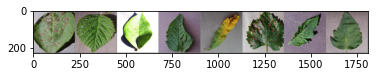

Potato___Early_blight Raspberry___healthy Blueberry___healthy Tomato___Septoria_leaf_spot Peach___Bacterial_spot Grape___Esca_(Black_Measles) Tomato___Tomato_mosaic_virus Tomato___Septoria_leaf_spot


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# load Mobile ViT for training and testing on our task

we also add a fully-connected layer at last for classification tasks

In [12]:
from transformers import MobileViTFeatureExtractor, MobileViTModel
from torch import nn

from transformers import AutoFeatureExtractor, SwinForImageClassification
from PIL import Image
import requests


class MobileViTForImageClassification2(nn.Module):

    def __init__(self, num_labels):

        super(MobileViTForImageClassification2, self).__init__()
        #self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.vit = MobileViTModel.from_pretrained("apple/mobilevit-small")
        #print(self.vit.config)
        self.classifier = nn.Linear(640*7*7, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values):

        outputs = self.vit(pixel_values=pixel_values)
        #print(outputs.last_hidden_state.shape)
        flatterned = torch.flatten(outputs.last_hidden_state, start_dim=1)
        logits = self.classifier(flatterned)
        #print(logits)
        #last_hidden_states=outputs.last_hidden_state
        #logits = self.classifier(last_hidden_states[:,0,:])
        return logits

model=MobileViTForImageClassification2(num_labels=len(classes))
model.load_state_dict(torch.load("./Mobilevit_leaf_classify.pth", map_location=torch.device(device)))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma = gamma,step_size=step_size, verbose = True)


Some weights of the model checkpoint at apple/mobilevit-small were not used when initializing MobileViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing MobileViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MobileViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Adjusting learning rate of group 0 to 5.0000e-03.


# Count the number of parameters in model

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

6129350

In [14]:
# just for testing, you can ignore it
temp_img=torch.rand((1,3,224,224)).to(device)
res=model(temp_img)
res.shape

torch.Size([1, 38])

# if you have any model already trained, you can use the following code to load it

In [ ]:
model.load_state_dict(torch.load("./Mobilevit_leaf_classify.pth"))

# Train the model

In [10]:
import gc

epoch=22

for each in range(epoch):  # loop over the dataset multiple times
    print("epoch ", each)
    running_loss = 0.0
    model.train()
    for i, data in enumerate(trainloader, 0):
        #gc.collect()
        #torch.cuda.empty_cache()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device),data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #break
    valid_loss = 0.0
    model.eval()
    for i, data in enumerate(validloader,0):
        #gc.collect()
        #torch.cuda.empty_cache()
        inputs, labels = data[0].to(device),data[1].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #print(type(loss), loss)
        valid_loss += loss.item()

    scheduler.step()
    print(f' train loss: {running_loss / len(trainloader)}, valid loss: {valid_loss / len(validloader)}')
    torch.save(model.state_dict(), './Mobilevit_leaf_classify.pth')
    running_loss = 0.0       

print('Finished Training')
print("...")
torch.save(model.state_dict(), './Mobilevit_leaf_classify.pth')
print("Training saved")

epoch  0
Adjusting learning rate of group 0 to 5.0000e-03.
 train loss: 0.04035941268495945, valid loss: 0.07354270313353267
epoch  1
Adjusting learning rate of group 0 to 5.0000e-03.
 train loss: 0.033574829427140886, valid loss: 0.09516054420575563
epoch  2
Adjusting learning rate of group 0 to 5.0000e-03.
 train loss: 0.02917004856893236, valid loss: 0.10093347533740957
epoch  3
Adjusting learning rate of group 0 to 5.0000e-03.
 train loss: 0.03252825774667879, valid loss: 0.09336905483012434
epoch  4
Adjusting learning rate of group 0 to 5.0000e-03.
 train loss: 0.02129005522997685, valid loss: 0.10282674173352836
epoch  5
Adjusting learning rate of group 0 to 5.0000e-03.
 train loss: 0.021743432214231938, valid loss: 0.09556906134480762
epoch  6
Adjusting learning rate of group 0 to 5.0000e-03.
 train loss: 0.021548460754739124, valid loss: 0.07002853063927787
epoch  7
Adjusting learning rate of group 0 to 5.0000e-03.
 train loss: 0.014817979715319772, valid loss: 0.08669272564277

# Test the performance of model on the test set

In [15]:
from collections import defaultdict

# number of pictures correctly classified in correct labels
correct_pred = {classname: 0 for classname in classes}
# number of 
total_pred = {classname: 0 for classname in classes}
error = defaultdict(lambda: [])

model.to(device)
# again no gradients needed
with torch.no_grad():
    index=0
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        #print(outputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for i, (label, prediction) in enumerate(zip(labels, predictions)):
            if label == prediction:
                correct_pred[classes[label]] += 1
            else:
                error[classes[label]].append((index+i, prediction.item()))
            total_pred[classes[label]] += 1
        index+=8



# check for accuracy of each class

In [18]:

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:50s} is {accuracy:.1f} %')

Accuracy for class: Apple___Apple_scab                                 is 100.0 %
Accuracy for class: Apple___Black_rot                                  is 100.0 %
Accuracy for class: Apple___Cedar_apple_rust                           is 100.0 %
Accuracy for class: Apple___healthy                                    is 100.0 %
Accuracy for class: Blueberry___healthy                                is 99.3 %
Accuracy for class: Cherry_(including_sour)___healthy                  is 100.0 %
Accuracy for class: Cherry_(including_sour)___Powdery_mildew           is 100.0 %
Accuracy for class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot is 91.3 %
Accuracy for class: Corn_(maize)___Common_rust_                        is 99.6 %
Accuracy for class: Corn_(maize)___healthy                             is 100.0 %
Accuracy for class: Corn_(maize)___Northern_Leaf_Blight                is 100.0 %
Accuracy for class: Grape___Black_rot                                  is 100.0 %
Accuracy for class:

In [19]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')

Accuracy of the network on the test images: 99.28 %


torch.Size([3, 228, 1810])


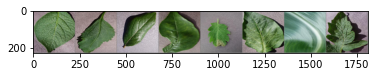

Potato___Late_blight Cherry_(including_sour)___Powdery_mildew Blueberry___healthy Orange___Haunglongbing_(Citrus_greening) Tomato___healthy Pepper,_bell___healthy Corn_(maize)___Northern_Leaf_Blight Tomato___Spider_mites Two-spotted_spider_mite


In [43]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
print(torchvision.utils.make_grid(images).shape)
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

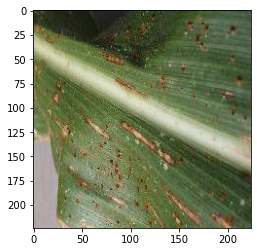

error for classifying: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot AS Corn_(maize)___healthy


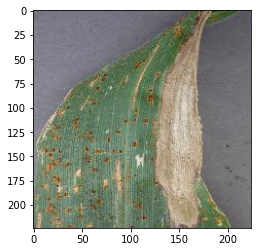

error for classifying: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot AS Corn_(maize)___healthy


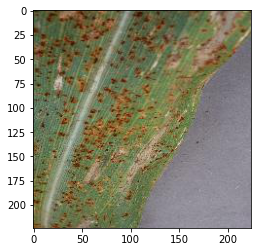

error for classifying: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot AS Corn_(maize)___healthy


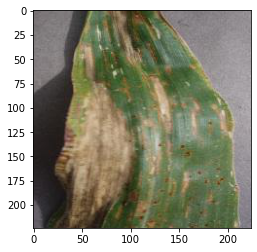

error for classifying: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot AS Corn_(maize)___healthy


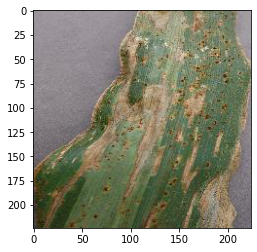

error for classifying: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot AS Corn_(maize)___healthy


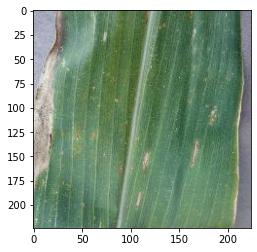

error for classifying: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot AS Corn_(maize)___healthy


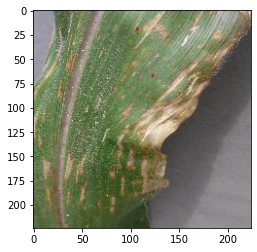

error for classifying: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot AS Corn_(maize)___healthy


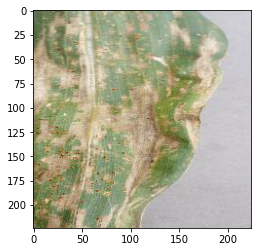

error for classifying: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot AS Corn_(maize)___healthy


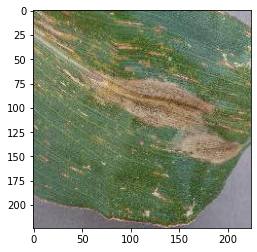

error for classifying: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot AS Corn_(maize)___healthy


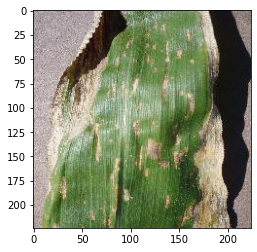

error for classifying: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot AS Corn_(maize)___healthy


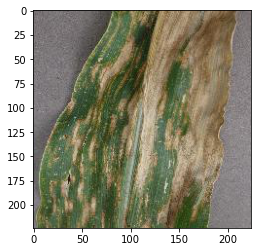

error for classifying: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot AS Corn_(maize)___healthy


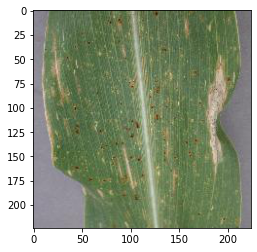

error for classifying: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot AS Corn_(maize)___healthy


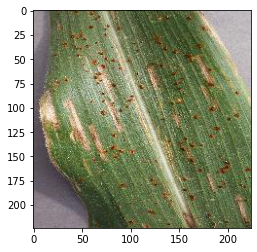

error for classifying: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot AS Corn_(maize)___healthy


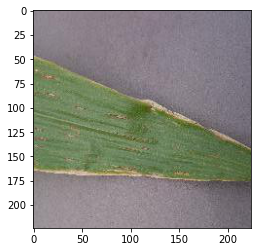

error for classifying: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot AS Corn_(maize)___healthy


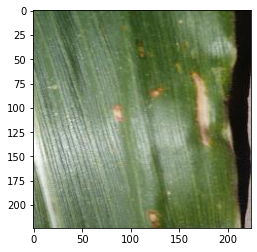

error for classifying: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot AS Apple___Cedar_apple_rust


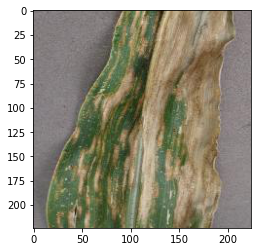

error for classifying: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot AS Corn_(maize)___healthy


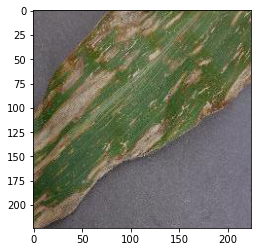

error for classifying: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot AS Corn_(maize)___healthy


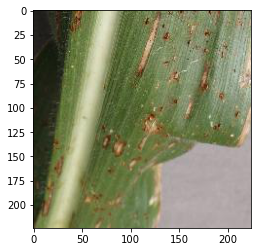

error for classifying: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot AS Corn_(maize)___healthy


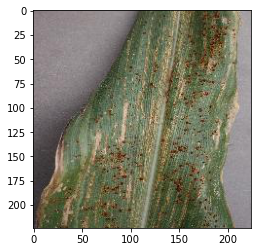

error for classifying: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot AS Corn_(maize)___healthy


In [12]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for class_name, error_indices in error.items():
    if class_name == "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot":
        for index, predict in error_indices:
            imshow(testset[index][0])
            print(f"error for classifying: {class_name} AS {classes[predict]}")